In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable
from transformer_attention import *

In [52]:
ntokens = 7
N = 3
n_heads = 8
embed_size = 512
seq_len = 11
dep_len = 6
smoothing = 0.001

epochs = 50
num_batches = 50
batch_size = 16
num_eval_batches = 20
log_interval = 10
warmup_steps = 3
decay_factor = 0.5
clip = 2
lr = 0.5

In [3]:
# Generate some token transition probabilities
probs = np.random.randint(1, 10*ntokens, size = tuple(ntokens for _ in range(dep_len+1)))
# Normalize
probs = probs / (probs.sum(axis = -1)[..., np.newaxis])
probs.shape

(7, 7, 7, 7, 7, 7, 7)

Trains a model that uses the Transformer Attention mechanism as described in ["Attention is All You Need" (Vaswani, et al.)](https://arxiv.org/abs/1706.03762)

# Initialization and Setup
The `TransformerAttention` class is defined in the file `transformer_attention.py`.

## Model definition

In [4]:
class TestModel(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, N = 6,
                 embed_size = 512, ff_size = 2048,
                 num_attn_heads = 8, dropout = 0.1):
        super(TestModel, self).__init__()
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.N = N
        self.embed_size = embed_size
        self.ff_size = ff_size
        self.num_attn_heads = num_attn_heads
        
        self.dropout = nn.Dropout(dropout)
        self.src_embedding = nn.Embedding(src_vocab, embed_size)
        self.tgt_embedding = nn.Embedding(tgt_vocab, embed_size)
        self.attn = TransformerAttention(
            src_vocab, tgt_vocab, d_model = embed_size,
            d_ff = ff_size, h = num_attn_heads, N = N,
            dropout = dropout
        )
        self.projection = nn.Linear(embed_size, tgt_vocab)
        self.log_softmax = nn.LogSoftmax(-1)
        
        #self.src_embedding.weight = self.projection.weight
        self.tgt_embedding.weight = self.projection.weight
        
    def init(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform(p)
            else:
                p.data.fill_(0)
                
    def forward(self, src, tgt, src_mask = None, tgt_mask = None):
        src_embeddings = self.dropout(self.src_embedding(src))
        tgt_embeddings = self.dropout(self.tgt_embedding(tgt))
        
        attentions = self.attn(src_embeddings, tgt_embeddings, src_mask, tgt_mask)
        
        logits = self.projection(self.dropout(attentions))
        # LabelSmoothing loss requires the model output log-softmax
        outputs = self.log_softmax(logits)
        return outputs

## Loss function definition (with label smoothing regularization)

During training, we employ label smoothing of value $\epsilon_{\text{lr}} = 0.1$. This hurts perplexity as the model learns to be more unsure, but it improves accuracy and BLEU score.

We implement label smoothing using the KL divergence loss. Instead of using a one-hot target distribution, we create a distribution that has `confidence` of the correct word and the rest of the `smoothing` mass distributed throughout the vocabulary.

In [5]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx = None, smoothing = 0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss()
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = torch.zeros_like(x.data)
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist.add_(self.smoothing / self.size)
        if self.padding_idx is not None:
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad = False)) * ntokens

Example of how the probability mass is distributed to the words based on confidence:

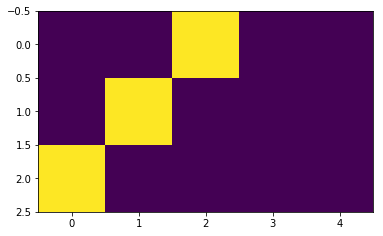

In [6]:
# Example of label smoothing.
crit = LabelSmoothing(5, None, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)

Label smoothing actually starts to penalize the model if it gets very confident about a given choice:

## Optimizer
Learning rate scheduler that sets the learning rate factor according to:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{epoch}^{-0.5}, \text{epoch}\cdot\text{warmup}^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first $\text{warmup}$ epochs, then decreasing it proportionally to the inverse square root of the epoch number.


In [7]:
def get_lr_scheduler(h_size, warmup, optimizer):
    lrate = lambda e: h_size**(-0.5) * min((e+1)**(-decay_factor), (e+1) * warmup**(-(decay_factor+1)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lrate)

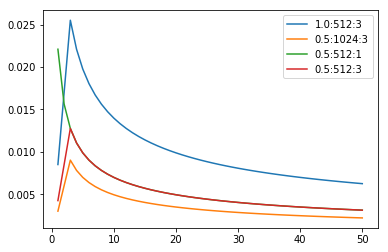

In [8]:
lrate = lambda factor, h_size, warmup: lambda e: factor*(h_size**(-0.5) * min(e**(-decay_factor), e * warmup**(-(decay_factor+1))))
opts = [
    lrate(2*lr, embed_size, warmup_steps), 
    lrate(lr, embed_size*2, warmup_steps),
    lrate(lr, embed_size, warmup_steps//2),
    lrate(lr, embed_size, warmup_steps),
]
plt.plot(np.arange(1, epochs+1), [[opt(i) for opt in opts] for i in range(1, epochs+1)])
plt.legend([
    "%.1f:%d:%d" % (2*lr, embed_size, warmup_steps),
    "%.1f:%d:%d" % (lr, embed_size*2, warmup_steps),
    "%.1f:%d:%d" % (lr, embed_size, warmup_steps//2),
    "%.1f:%d:%d" % (lr, embed_size, warmup_steps),
])

# Initialization
Initialize model, criterion, and optimizer

In [9]:
model = TestModel(ntokens, ntokens, embed_size = embed_size, N = N)
model.init()
criterion = LabelSmoothing(ntokens, smoothing = smoothing)
optimizer = optim.Adam(model.parameters(), lr = lr)
lr_scheduler = get_lr_scheduler(embed_size, warmup_steps, optimizer)
nparams = sum([p.numel() for p in model.parameters()])
print('Model parameters: %d' % nparams)

Model parameters: 9223


## Generate data

In [10]:
def gen_data(num_batches, batch_size, seq_len):
    num_data = num_batches * batch_size * seq_len
    # Initialize numpy array for the generated data
    data = np.zeros((num_data,), dtype = int)
    # Randomly generate a series of starting tokens
    ts = [np.random.randint(ntokens, size = 1) for _ in range(dep_len)]
    # Generate the data
    for i in range(num_data):
        pr = probs[ts].squeeze()
        data[i] = np.random.choice(ntokens, p = pr)
        ts.pop(0)
        ts.append(data[i].reshape(1,1))
    return torch.from_numpy(data).type(torch.LongTensor)

# Train and evaluate
## Training helpers
Classes and functions that handle generating batches of test data and running a single training iteration.

In [11]:
def batchify(data, batch_size):
    nbatches = data.size(0) // batch_size
    data = data.narrow(0, 0, nbatches * batch_size)
    data = data.view(batch_size, -1).contiguous()
    return data

In [12]:
train_data = batchify(gen_data(num_batches, batch_size, seq_len), batch_size)
test_data = batchify(gen_data(num_eval_batches, batch_size, seq_len), batch_size)
val_data = batchify(gen_data(num_eval_batches, batch_size, seq_len), batch_size)
train_data.shape, test_data.shape, val_data.shape

(torch.Size([16, 550]), torch.Size([16, 220]), torch.Size([16, 220]))

In [13]:
def get_batch(src, i, seq_len, evaluate = False):
    seq_len = min(seq_len, src.size(1) - 2 - i)
    data = Variable(src[:, i+1 : i+seq_len+1].contiguous(), volatile = evaluate)
    prev = Variable(src[:, i : i+seq_len].contiguous(), volatile = evaluate)
    targets = Variable(src[:, i+2 : i+seq_len+2].contiguous(), volatile = evaluate)
    return data, prev, targets

In [14]:
# Training loop
def train():
    # Use random length sequences
    seq_lens = []
    tot_len = 0
    jitter = 0.05 * seq_len
    num_data = train_data.size(1)
    while tot_len < num_data - 3:
        if num_data - tot_len - 3 < seq_len + jitter:
            slen = num_data - tot_len - 3
        else:
            slen = int(np.random.normal(seq_len, jitter))
            if slen <= 0:
                slen = seq_len    # eh
            if tot_len + slen >= num_data - jitter - 3:
                slen = num_data - tot_len - 3
        seq_lens.append(slen)
        tot_len += slen
    i_cumseq = [0] + list(np.cumsum(seq_lens)[:-1])
    idx = np.arange(len(seq_lens))
    np.random.shuffle(idx)
    # Turn on training mode
    model.train()
    # Pre metainfo
    total_loss = 0
    start_time = time.time()
    for batch, i in enumerate(idx):
        # Get training data
        data, prev, targets = get_batch(train_data, i_cumseq[i], seq_lens[i])
        # Zero out gradients
        model.zero_grad()
        
        # Run the model forward
        output = model(data, prev)
        if np.isnan(output.data).any():
            return 0, data, prev, targets
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets.view(-1))
        if np.isnan(loss.data[0]):
            return 1, data, prev, targets
        # Propagate loss gradient backwards
        loss.backward()
        # Clip gradients
        if batch % log_interval == 0 and batch > 0:
            # Save gradient statistics before they're changed cuz we'll be logging this batch
            parameters = [p for p in model.parameters() if p.grad is not None]
            # Calculate the largest (absolute) gradient of all elements in the model parameters
            max_grad = max([p.grad.data.abs().max() for p in parameters])
        total_norm = nn.utils.clip_grad_norm(model.parameters(), clip)
        # Scale the batch learning rate so that shorter sequences aren't "stronger"
        scaled_lr = lr_scheduler.get_lr()[0] * np.sqrt(seq_lens[i] / seq_len)
        for param_group in optimizer.param_groups:
            param_group['lr'] = scaled_lr
        # Update parameters
        optimizer.step()
        
        # Metainfo logging
        total_loss += loss.data
        if batch % log_interval == 0 and batch > 0:
            elapsed = time.time() - start_time
            cur_loss = total_loss[0] / log_interval
            print(' b {:3d}/{:3d} >> {:6.1f} ms/b | lr: {:4.2f} | grad norm: {:4.2f} | max abs grad: {:4.2f} | loss: {:4.2f} | perp.: {:5.2f}'.format(
                batch, len(seq_lens), elapsed * 1000/log_interval, scaled_lr, total_norm, max_grad, cur_loss, np.exp(cur_loss)
            ))
            total_loss = 0
            start_time = time.time()
    return -1, None, None, None

In [15]:
def evaluate(data_src):
    model.eval()
    total_loss = 0
    for i in range(0, data_src.size(1) - 2, seq_len):
        # Get data
        data, prev, targets = get_batch(data_src, i, seq_len, evaluate = True)
        # Zero out gradients
        model.zero_grad()
        
        # Run model forward
        output = model(data, prev)
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets.view(-1))
        total_loss += loss.data * data.size(1)
    return total_loss[0] / (data.size(1) - 2)

Train and evaluate

In [16]:
WIDTH = 104
CAUSES = ['output', 'grad']
for epoch in range(epochs):
    lr_scheduler.step()
    print('Epoch {:3d}/{:3d}) lr = {:.4g}{}'.format(epoch+1, epochs, np.mean(lr_scheduler.get_lr()[0]), ' (warmup)' if epoch < warmup_steps else ''))
    start_time = time.time()
    stat, data, prev, targets = train()
    if stat in list(range(len(CAUSES))):
        c = CAUSES[stat]
        n = (WIDTH - len(c) - 4) // 2
        print('\n' + (' '*n) + 'NaN ' + c)
        break
    elapsed = time.time() - start_time
    val_loss = evaluate(val_data)
    max_param = max([p.data.abs().max() for p in model.parameters() if p.grad is not None])
    print('-' * WIDTH)
    print('Elapsed time: {:5.2f} sec | max abs wt: {:5.2f} | valid_loss: {:5.2f} | valid_perplexity: {:5.2f}'.format(
        elapsed, max_param, val_loss, np.exp(val_loss)
    ))
    print('=' * WIDTH)
    print('\n')

Epoch   1/ 50) lr = 0.004253 (warmup)
 b  10/ 53 >>  569.7 ms/b | lr: 0.00 | grad norm: 0.19 | max abs grad: 0.05 | loss: 2.14 | perp.:  8.48
 b  20/ 53 >>  531.7 ms/b | lr: 0.00 | grad norm: 0.15 | max abs grad: 0.05 | loss: 1.94 | perp.:  6.97
 b  30/ 53 >>  519.7 ms/b | lr: 0.00 | grad norm: 0.17 | max abs grad: 0.05 | loss: 1.94 | perp.:  6.97
 b  40/ 53 >>  504.8 ms/b | lr: 0.00 | grad norm: 0.15 | max abs grad: 0.04 | loss: 1.94 | perp.:  6.96
 b  50/ 53 >>  503.1 ms/b | lr: 0.00 | grad norm: 0.17 | max abs grad: 0.04 | loss: 1.94 | perp.:  6.96
------------------------------------------------------------------------------------------------------
Elapsed time: 26.65 sec | max abs wt:  0.28 | valid_loss:  3.87 | valid_perplexity: 48.03


Epoch   2/ 50) lr = 0.008505 (warmup)
 b  10/ 52 >>  548.6 ms/b | lr: 0.01 | grad norm: 0.17 | max abs grad: 0.06 | loss: 2.14 | perp.:  8.48
 b  20/ 52 >>  554.7 ms/b | lr: 0.01 | grad norm: 0.17 | max abs grad: 0.07 | loss: 1.94 | perp.:  6.97
 

------------------------------------------------------------------------------------------------------
Elapsed time: 26.15 sec | max abs wt:  4.55 | valid_loss:  2.24 | valid_perplexity:  9.40


Epoch  11/ 50) lr = 0.006663
 b  10/ 53 >>  536.7 ms/b | lr: 0.01 | grad norm: 0.37 | max abs grad: 0.04 | loss: 1.31 | perp.:  3.70
 b  20/ 53 >>  520.2 ms/b | lr: 0.01 | grad norm: 0.38 | max abs grad: 0.04 | loss: 1.27 | perp.:  3.58
 b  30/ 53 >>  486.0 ms/b | lr: 0.01 | grad norm: 0.37 | max abs grad: 0.04 | loss: 1.20 | perp.:  3.30
 b  40/ 53 >>  519.0 ms/b | lr: 0.01 | grad norm: 0.32 | max abs grad: 0.03 | loss: 1.20 | perp.:  3.31
 b  50/ 53 >>  525.8 ms/b | lr: 0.01 | grad norm: 0.37 | max abs grad: 0.05 | loss: 1.20 | perp.:  3.33
------------------------------------------------------------------------------------------------------
Elapsed time: 26.31 sec | max abs wt:  4.78 | valid_loss:  2.22 | valid_perplexity:  9.24


Epoch  12/ 50) lr = 0.006379
 b  10/ 52 >>  566.9 ms/b | lr: 

 b  40/ 52 >>  495.9 ms/b | lr: 0.00 | grad norm: 0.41 | max abs grad: 0.05 | loss: 1.09 | perp.:  2.96
 b  50/ 52 >>  481.8 ms/b | lr: 0.00 | grad norm: 0.42 | max abs grad: 0.08 | loss: 1.12 | perp.:  3.05
------------------------------------------------------------------------------------------------------
Elapsed time: 25.62 sec | max abs wt:  6.28 | valid_loss:  1.80 | valid_perplexity:  6.04


Epoch  21/ 50) lr = 0.004822
 b  10/ 53 >>  551.0 ms/b | lr: 0.00 | grad norm: 0.31 | max abs grad: 0.03 | loss: 1.14 | perp.:  3.12
 b  20/ 53 >>  506.7 ms/b | lr: 0.00 | grad norm: 0.44 | max abs grad: 0.04 | loss: 1.09 | perp.:  2.98
 b  30/ 53 >>  488.5 ms/b | lr: 0.00 | grad norm: 0.36 | max abs grad: 0.03 | loss: 1.09 | perp.:  2.97
 b  40/ 53 >>  500.1 ms/b | lr: 0.00 | grad norm: 0.30 | max abs grad: 0.02 | loss: 1.09 | perp.:  2.99
 b  50/ 53 >>  515.2 ms/b | lr: 0.00 | grad norm: 0.37 | max abs grad: 0.03 | loss: 1.05 | perp.:  2.85
------------------------------------------------

 b  20/ 53 >>  525.4 ms/b | lr: 0.00 | grad norm: 0.37 | max abs grad: 0.03 | loss: 1.07 | perp.:  2.91
 b  30/ 53 >>  499.5 ms/b | lr: 0.00 | grad norm: 0.39 | max abs grad: 0.03 | loss: 1.02 | perp.:  2.77
 b  40/ 53 >>  512.4 ms/b | lr: 0.00 | grad norm: 0.36 | max abs grad: 0.04 | loss: 1.04 | perp.:  2.83
 b  50/ 53 >>  496.2 ms/b | lr: 0.00 | grad norm: 0.36 | max abs grad: 0.03 | loss: 1.04 | perp.:  2.82
------------------------------------------------------------------------------------------------------
Elapsed time: 26.58 sec | max abs wt:  7.33 | valid_loss:  1.72 | valid_perplexity:  5.56


Epoch  31/ 50) lr = 0.003969
 b  10/ 52 >>  542.3 ms/b | lr: 0.00 | grad norm: 0.42 | max abs grad: 0.04 | loss: 1.10 | perp.:  2.99
 b  20/ 52 >>  507.6 ms/b | lr: 0.00 | grad norm: 0.39 | max abs grad: 0.04 | loss: 1.06 | perp.:  2.89
 b  30/ 52 >>  537.9 ms/b | lr: 0.00 | grad norm: 0.43 | max abs grad: 0.04 | loss: 1.04 | perp.:  2.84
 b  40/ 52 >>  522.2 ms/b | lr: 0.00 | grad norm

 b  10/ 52 >>  588.6 ms/b | lr: 0.00 | grad norm: 0.38 | max abs grad: 0.03 | loss: 1.06 | perp.:  2.89
 b  20/ 52 >>  528.8 ms/b | lr: 0.00 | grad norm: 0.33 | max abs grad: 0.03 | loss: 1.02 | perp.:  2.77
 b  30/ 52 >>  526.1 ms/b | lr: 0.00 | grad norm: 0.38 | max abs grad: 0.04 | loss: 1.00 | perp.:  2.72
 b  40/ 52 >>  508.0 ms/b | lr: 0.00 | grad norm: 0.39 | max abs grad: 0.03 | loss: 0.99 | perp.:  2.70
 b  50/ 52 >>  516.5 ms/b | lr: 0.00 | grad norm: 0.55 | max abs grad: 0.07 | loss: 1.03 | perp.:  2.79
------------------------------------------------------------------------------------------------------
Elapsed time: 26.84 sec | max abs wt:  8.00 | valid_loss:  1.57 | valid_perplexity:  4.80


Epoch  41/ 50) lr = 0.003451
 b  10/ 52 >>  574.7 ms/b | lr: 0.00 | grad norm: 0.35 | max abs grad: 0.02 | loss: 1.07 | perp.:  2.91
 b  20/ 52 >>  501.6 ms/b | lr: 0.00 | grad norm: 0.38 | max abs grad: 0.04 | loss: 1.02 | perp.:  2.78
 b  30/ 52 >>  533.5 ms/b | lr: 0.00 | grad norm

 b  10/ 52 >>  547.3 ms/b | lr: 0.00 | grad norm: 0.37 | max abs grad: 0.03 | loss: 1.05 | perp.:  2.86
 b  20/ 52 >>  512.0 ms/b | lr: 0.00 | grad norm: 0.34 | max abs grad: 0.03 | loss: 1.03 | perp.:  2.79
 b  30/ 52 >>  523.5 ms/b | lr: 0.00 | grad norm: 0.42 | max abs grad: 0.05 | loss: 0.99 | perp.:  2.68
 b  40/ 52 >>  491.2 ms/b | lr: 0.00 | grad norm: 0.39 | max abs grad: 0.04 | loss: 0.96 | perp.:  2.61
 b  50/ 52 >>  472.3 ms/b | lr: 0.00 | grad norm: 0.63 | max abs grad: 0.07 | loss: 1.02 | perp.:  2.77
------------------------------------------------------------------------------------------------------
Elapsed time: 25.60 sec | max abs wt:  8.49 | valid_loss:  1.54 | valid_perplexity:  4.67




In [17]:
test_loss = evaluate(test_data)
print('test_loss: {:5.2f} | test_perplexity: {:5.2f}'.format(
    test_loss, np.exp(test_loss)
))

test_loss:  1.45 | test_perplexity:     4.25


## Evaluation
Check out the prediction quality

In [46]:
# Get a random sequence from the generated data starting from whatever point
data, prev, targets = get_batch(test_data, 120, seq_len)
# We'll just look at a few batches
nb = 4
data = data[:nb].contiguous()
prev = prev[:nb].contiguous()
targets = targets[:nb].contiguous()

In [47]:
# Run the model forward
output = model(data, prev)
# Convert to probabilities
output = output.exp()
# Get the max prob for each step
output_probs, output_idx = output.max(-1)

In [48]:
for i in range(nb):
    # Print the output with the targets
    seqs = torch.cat([targets[i].unsqueeze(0), output_idx[i].unsqueeze(0)], 0)
    # Number incorrectly predicted
    num_incorrect = (targets[i] != output_idx[i]).sum()
    print('%d incorrectly predicted\n' % num_incorrect[0], seqs)

3 incorrectly predicted
 Variable containing:
    6     5     3     3     0     5     4     2     5     4     6
    6     5     3     3     0     5     5     2     2     4     4
[torch.LongTensor of size 2x11]

3 incorrectly predicted
 Variable containing:
    2     6     4     3     1     1     2     5     1     6     4
    2     6     4     3     1     1     2     2     1     1     1
[torch.LongTensor of size 2x11]

4 incorrectly predicted
 Variable containing:
    4     3     1     1     5     4     0     6     1     1     2
    3     3     1     1     5     0     0     0     1     1     1
[torch.LongTensor of size 2x11]

2 incorrectly predicted
 Variable containing:
    0     6     1     2     3     5     5     1     4     0     2
    0     6     1     2     3     5     5     1     1     0     0
[torch.LongTensor of size 2x11]



## Visualizations

In [50]:
modules = list(model.modules())
list(enumerate(modules))

[(0, TestModel(
    (dropout): Dropout(p=0.1)
    (src_embedding): Embedding(7, 512)
    (tgt_embedding): Embedding(7, 512)
    (attn): TransformerAttention(
      (dropout): Dropout(p=0.1)
      (src_position): PositionalEncoding(
        (dropout): Dropout(p=0.1)
      )
      (tgt_position): PositionalEncoding(
        (dropout): Dropout(p=0.1)
      )
      (enc_norm): LayerNorm(
      )
      (dec_norm): LayerNorm(
      )
    )
    (projection): Linear(in_features=512, out_features=7)
    (log_softmax): LogSoftmax()
  )),
 (1, Dropout(p=0.1)),
 (2, Embedding(7, 512)),
 (3, Embedding(7, 512)),
 (4, TransformerAttention(
    (dropout): Dropout(p=0.1)
    (src_position): PositionalEncoding(
      (dropout): Dropout(p=0.1)
    )
    (tgt_position): PositionalEncoding(
      (dropout): Dropout(p=0.1)
    )
    (enc_norm): LayerNorm(
    )
    (dec_norm): LayerNorm(
    )
  )),
 (5, Dropout(p=0.1)),
 (6, PositionalEncoding(
    (dropout): Dropout(p=0.1)
  )),
 (7, Dropout(p=0.1)),
 (8,

In [51]:
attn_module = modules[4]

Visualize attention weights for the first sequence:

**Encoder attention weights**

Encoder layer 1


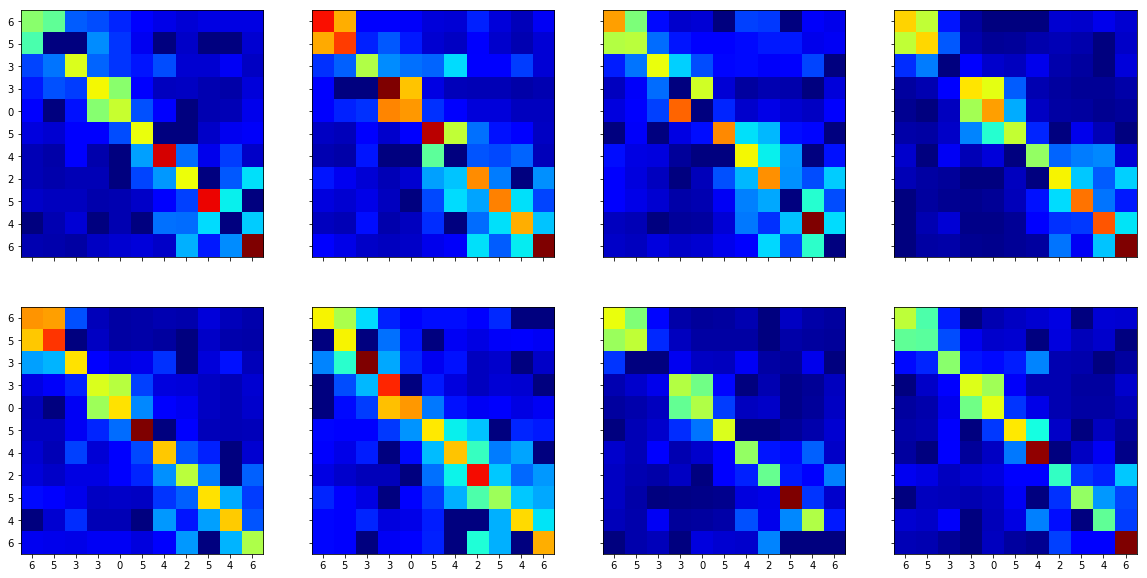

Encoder layer 2


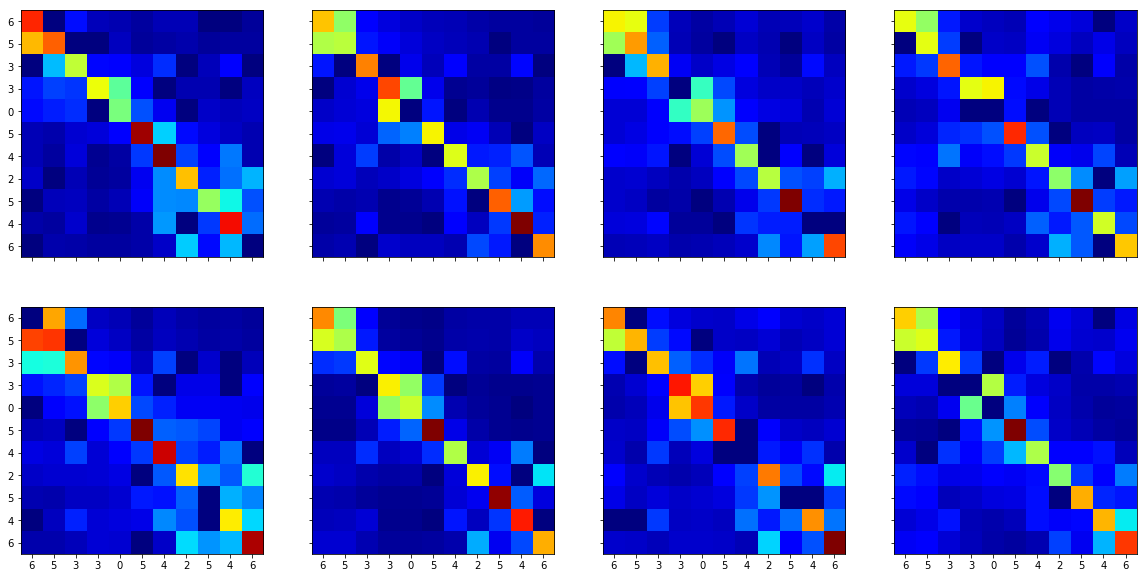

Encoder layer 3


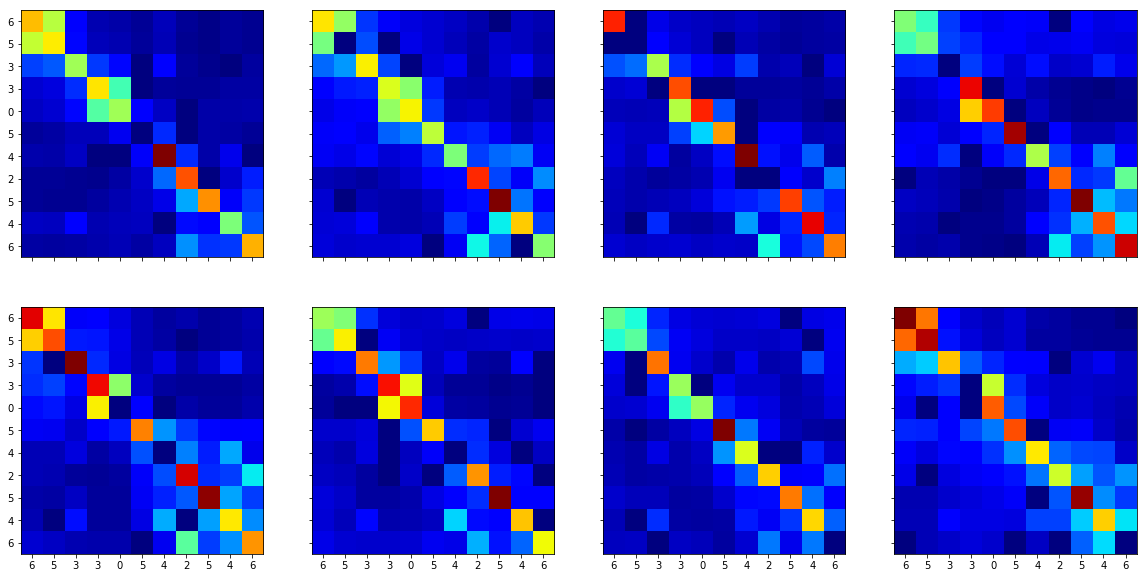

In [89]:
for layer in range(N):
    cols = 4
    rows = n_heads//cols
    fig, axs = plt.subplots(rows, cols, figsize = (20, 10))
    print("\nEncoder layer %d" % (layer+1))
    for h in range(n_heads):
        r = h // cols
        c = h % cols
        ax = axs[r, c]
        ax.imshow(
            attn_module.encoder_stack[layer].attn.attn[0, h].data[:seq_len, :seq_len],
            aspect = 'auto', cmap = 'jet'
        )
        # Fix labels
        s = list(targets[0].data)
        ax.set_xticks(range(seq_len))
        ax.set_xticklabels(s if r == rows-1 else [])
        ax.set_yticks(range(seq_len))
        ax.set_yticklabels(s if c == 0 else [])
    plt.show()

**Decoder self-attention weights**

Decoder self layer 1


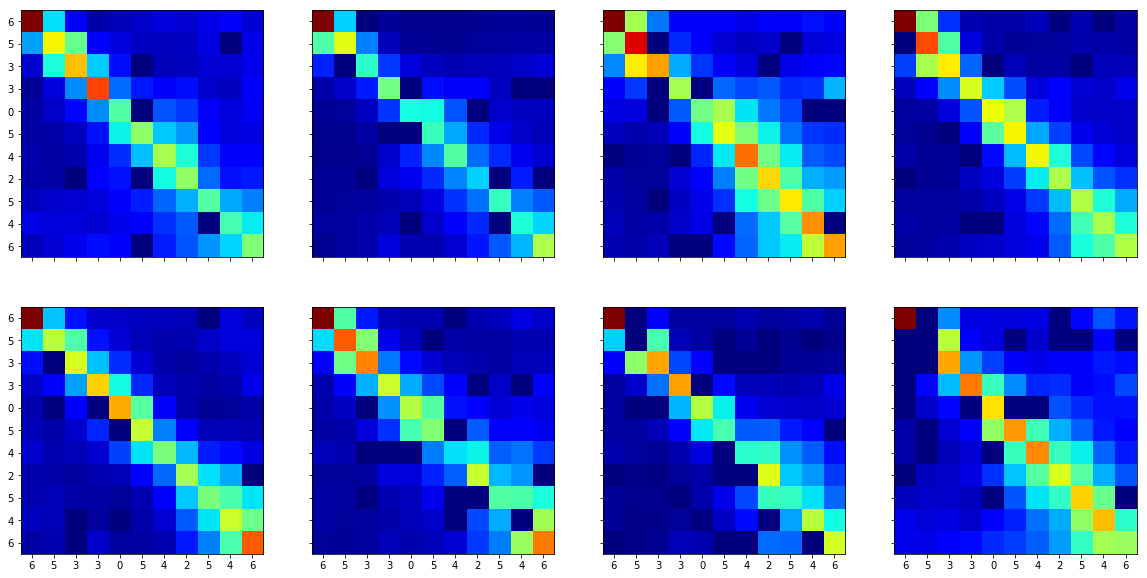

Decoder self layer 2


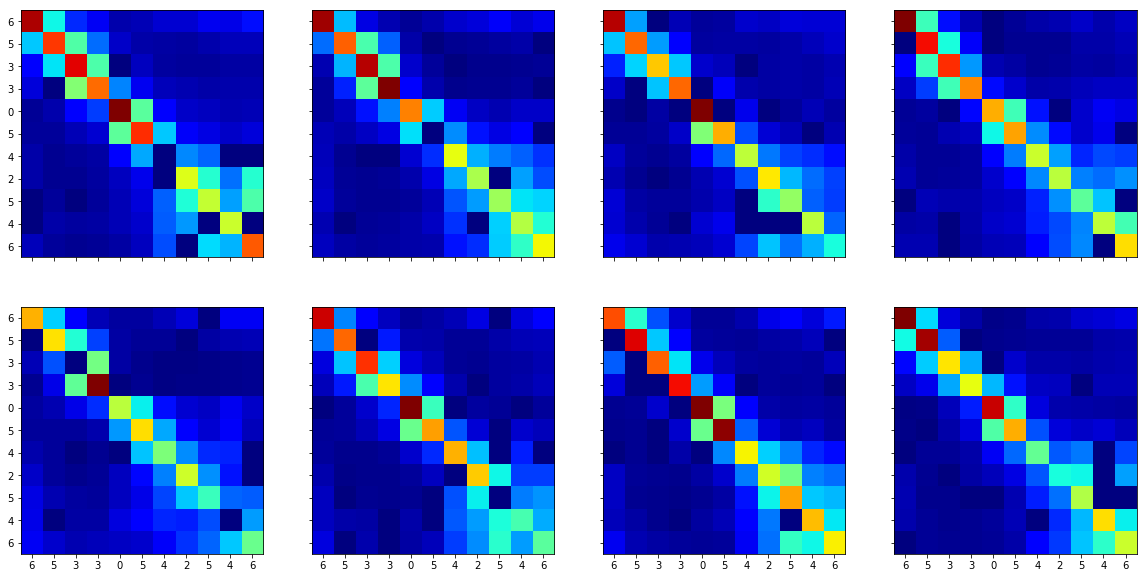

Decoder self layer 3


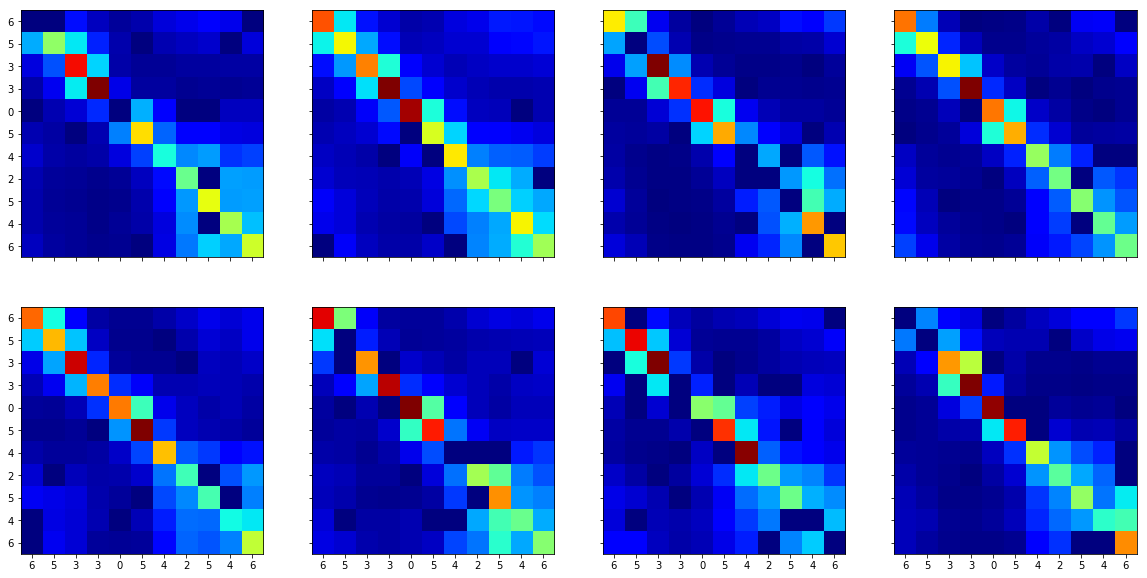

In [91]:
for layer in range(N):
    cols = 4
    rows = n_heads//cols
    # Self-attention weights
    fig, axs = plt.subplots(rows, cols, figsize = (20, 10))
    print("\nDecoder self layer %d" % (layer+1))
    for h in range(n_heads):
        r = h // cols
        c = h % cols
        ax = axs[r, c]
        ax.imshow(
            attn_module.decoder_stack[layer].self_attn.attn[0, h].data[:seq_len, :seq_len],
            aspect = 'auto', cmap = 'jet'
        )
        # Fix labels
        s = list(targets[0].data)
        ax.set_xticks(range(seq_len))
        ax.set_xticklabels(s if r == rows-1 else [])
        ax.set_yticks(range(seq_len))
        ax.set_yticklabels(s if c == 0 else [])
    plt.show()

**Decoder source-attention weights**

Decoder self layer 1


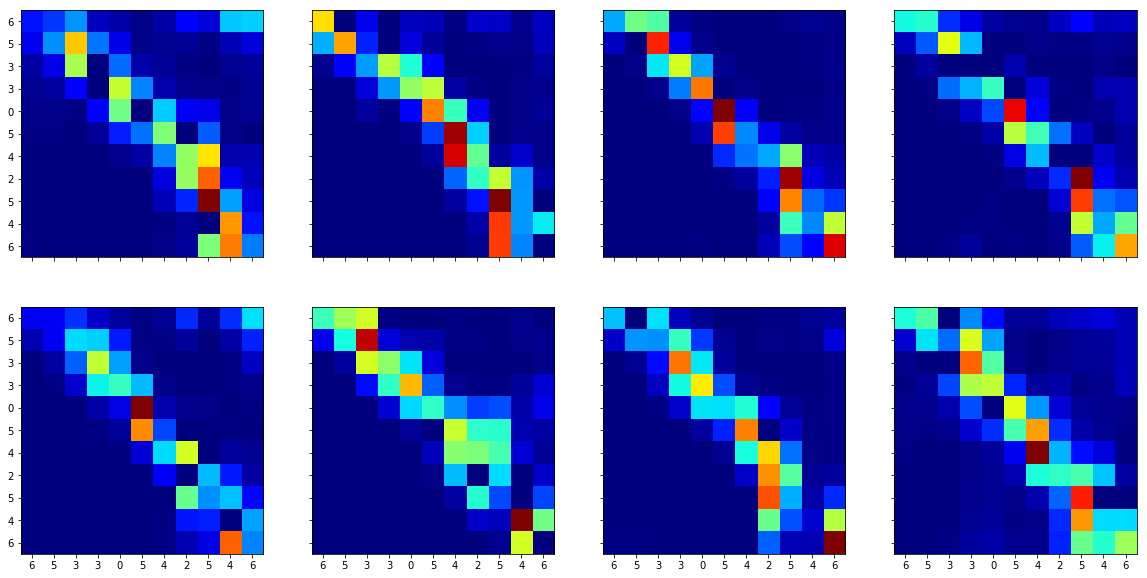

Decoder self layer 2


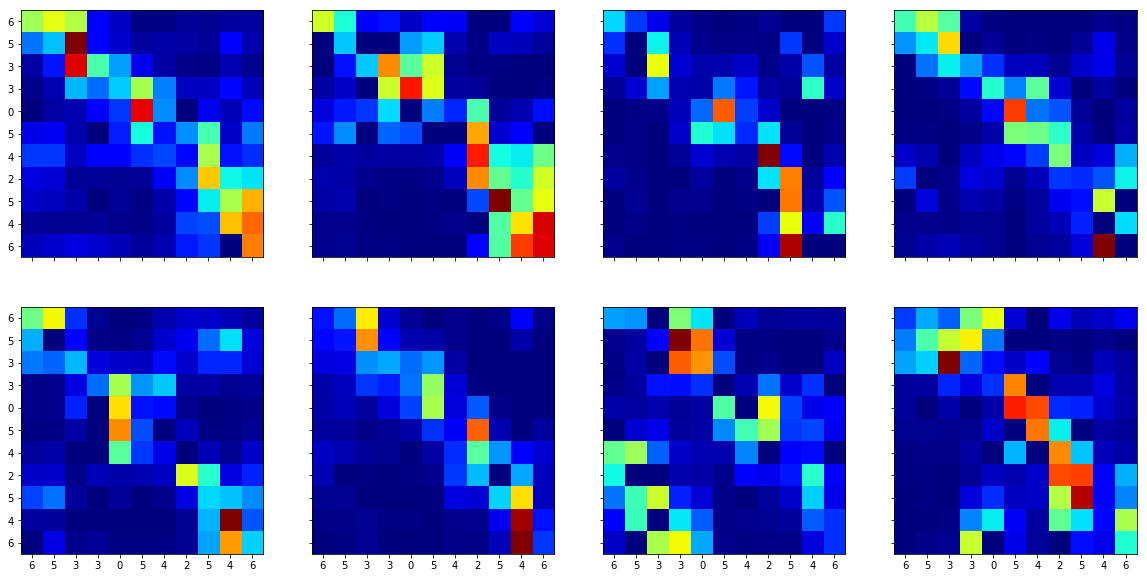

Decoder self layer 3


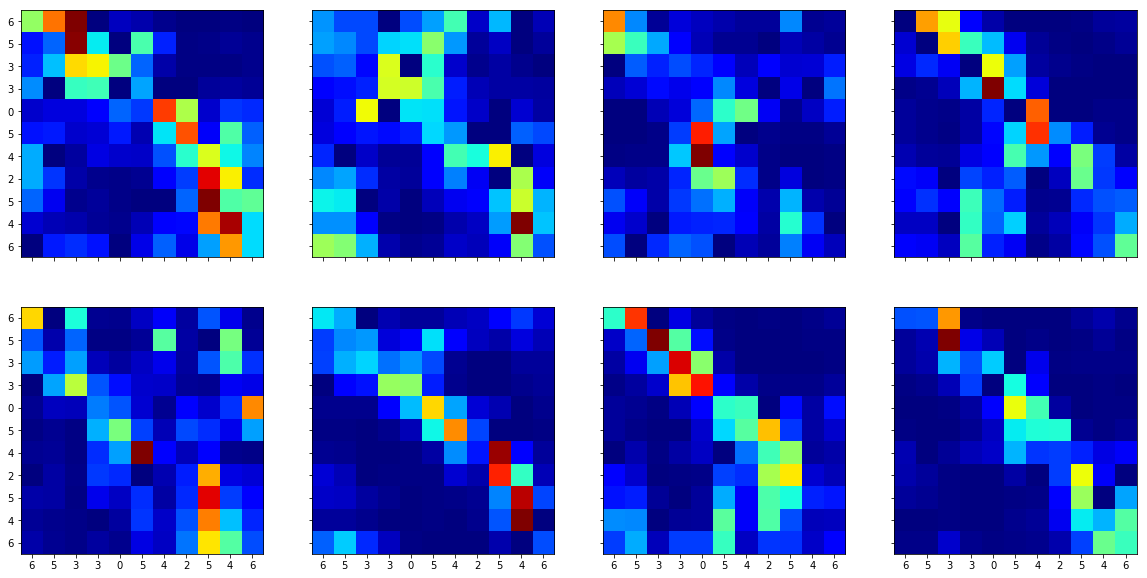

In [92]:
for layer in range(N):
    cols = 4
    rows = n_heads//cols
    # Self-attention weights
    fig, axs = plt.subplots(rows, cols, figsize = (20, 10))
    print("\nDecoder self layer %d" % (layer+1))
    for h in range(n_heads):
        r = h // cols
        c = h % cols
        ax = axs[r, c]
        ax.imshow(
            attn_module.decoder_stack[layer].src_attn.attn[0, h].data[:seq_len, :seq_len],
            aspect = 'auto', cmap = 'jet'
        )
        # Fix labels
        s = list(targets[0].data)
        ax.set_xticks(range(seq_len))
        ax.set_xticklabels(s if r == rows-1 else [])
        ax.set_yticks(range(seq_len))
        ax.set_yticklabels(s if c == 0 else [])
    plt.show()